In [ ]:
from datetime import datetime
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm

import trainer

## Read in NWM retrospective data and define the HUC8 bounding box

In [112]:
start_time = datetime.strptime("20190524 120000", "%Y%m%d %H%M%S")
end_time = datetime.strptime("20190527 120000", "%Y%m%d %H%M%S")
ds_r, ds_sm = trainer.read(start_time, end_time)

In [11]:
gdf = gpd.read_file("../data/boundaries/11070103_huc.gpkg")
bounds = gdf.total_bounds
bounds

array([   8050.4825034 , 1485040.28810941,   68027.65488072,
       1604408.48682579])

## Plot the bounding box around the HUC

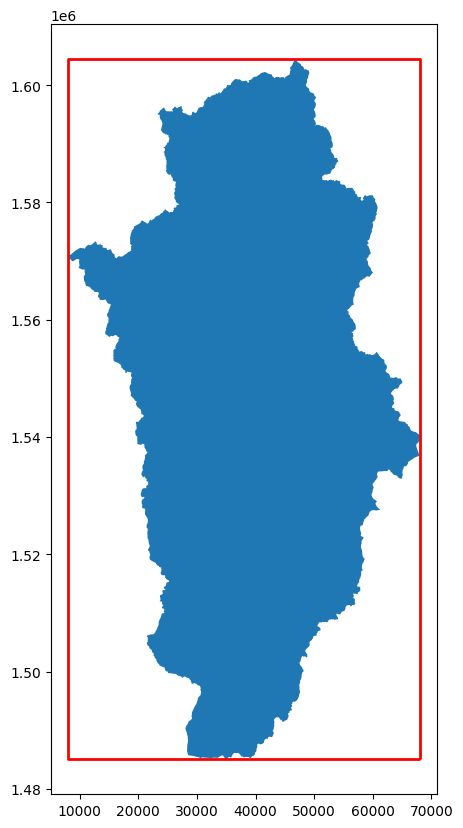

In [13]:
from shapely.geometry import box
bbox = box(*bounds)

# If you want to plot the bounding box along with your HUC8 shape
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs=gdf.crs)
bbox_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=2)
plt.show()

## Read the observation data, and clip it to the bounding box 

In [146]:
raster = rioxarray.open_rasterio("../data/sentinel/cloud_cutout_extent_filled_optimized.tif")
raster_5070 = raster.rio.reproject("EPSG:5070")

In [147]:
bounds = gdf.total_bounds
minx, miny, maxx, maxy = bounds
clipped_raster = raster_5070.rio.clip_box(
    minx=minx,
    miny=miny,
    maxx=maxx,
    maxy=maxy
)

clipped_raster.rio.to_raster("../data/sentinel/cloud_cutout_extent_clipped_huc8.tif")

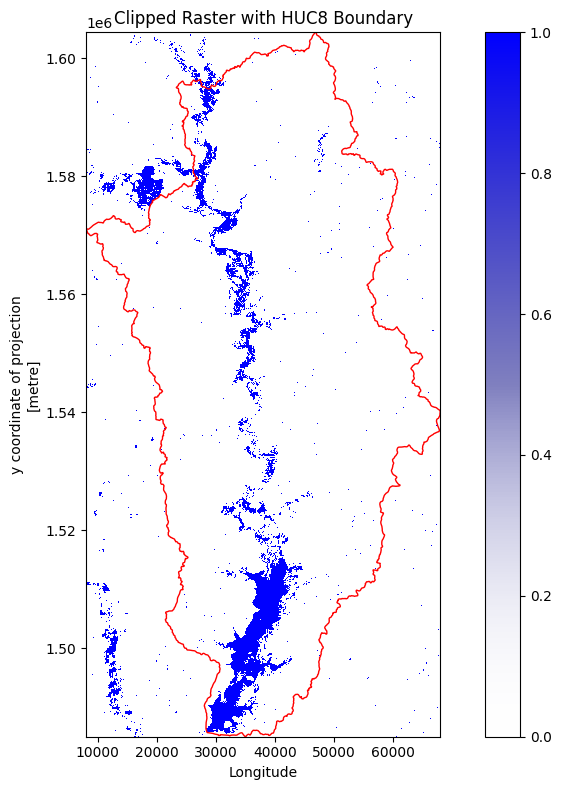

In [148]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = [(1, 1, 1, 0), (0, 0, 0.5, 0.5), (0, 0, 1, 1)]  # Transparent to dark blue
water_cmap = LinearSegmentedColormap.from_list("water_cmap", colors)
im2 = clipped_raster.plot(ax=ax, cmap=water_cmap, vmin=0, vmax=1)
ax.set_title("Raster with NoData filled as 0")
ax.set_xlabel("Longitude")

plt.tight_layout()

gdf.boundary.plot(ax=ax, color='red', linewidth=1)
plt.title('Clipped Raster with HUC8 Boundary')
plt.show()

## Resample to 250m, and find the percent surface water in each pixel

In [150]:
import numpy as np
from rasterio.enums import Resampling

def calculate_flood_percentage(raster, target_resolution=250):
    # Get the current resolution and dimensions
    current_res_x, current_res_y = raster.rio.resolution()
    current_width = raster.rio.width
    current_height = raster.rio.height
    
    # Calculate the scale factor
    scale_x = abs(target_resolution / current_res_x)
    scale_y = abs(target_resolution / current_res_y)
    
    # Calculate new dimensions
    new_width = int(current_width / scale_x)
    new_height = int(current_height / scale_y)
    
    # Create an empty array for our percentages
    percentages = np.zeros((raster.rio.count, new_height, new_width))
    
    # Get the data as a numpy array
    data = raster.values
    
    # For each band
    for b in range(raster.rio.count):
        # Get the band data
        band_data = data[b]
        
        # Identify pixels with value 1 (flooded)
        binary_mask = (band_data == 1).astype(np.float32)
        
        # Calculate percentage for each block
        for i in range(new_height):
            for j in range(new_width):
                # Calculate corresponding indices in the original raster
                start_y = int(i * scale_y)
                end_y = int(min((i + 1) * scale_y, current_height))
                start_x = int(j * scale_x)
                end_x = int(min((j + 1) * scale_x, current_width))
                
                # Extract the block from the original data
                block = binary_mask[start_y:end_y, start_x:end_x]
                
                # Calculate total number of valid pixels in the block
                total_pixels = block.size
                
                # Skip if no valid pixels (avoid division by zero)
                if total_pixels == 0:
                    percentages[b, i, j] = np.nan
                    continue
                
                # Calculate percentage of flooded pixels
                flood_count = np.sum(block)
                percentages[b, i, j] = (flood_count / total_pixels) * 100
    
    # Create a new raster with the percentages
    percentage_raster = raster.rio.reproject(
        raster.rio.crs,
        shape=(new_height, new_width),
        resampling=Resampling.nearest
    )
    
    # Replace the values with our percentages
    percentage_raster.values = percentages
    
    return percentage_raster

target_resolution = 250
# Apply the function to your reprojected raster
flood_percent_250m = calculate_flood_percentage(clipped_raster, target_resolution=target_resolution)

# Save the percentage raster
# flood_percent_250m.rio.to_raster("../data/sentinel/flood_percent_250m.tif")

# Print some statistics
total_flooded_pixels_original = (clipped_raster.values == 1).sum()

# Calculate the equivalent number of original pixels from the percentage data
# Each target pixel represents (scale_x * scale_y) original pixels
current_res_x, current_res_y = clipped_raster.rio.resolution()
scale_x = abs(target_resolution / current_res_x)
scale_y = abs(target_resolution / current_res_y)
pixels_per_target = scale_x * scale_y

# For each target pixel, its percentage tells us how many original pixels were flooded
# Sum up (percentage/100 * pixels_per_target) for all target pixels
equivalent_flooded_pixels = np.nansum(flood_percent_250m.values / 100 * pixels_per_target)

print(f"Total flooded pixels in original: {total_flooded_pixels_original}")
print(f"Equivalent flooded pixels from percentage raster: {equivalent_flooded_pixels:.1f}")
print(f"Difference: {equivalent_flooded_pixels - total_flooded_pixels_original:.1f} pixels")
print(f"Percentage difference: {((equivalent_flooded_pixels - total_flooded_pixels_original) / total_flooded_pixels_original) * 100:.2f}%")

Total flooded pixels in original: 151108
Equivalent flooded pixels from percentage raster: 151056.4
Difference: -51.6 pixels
Percentage difference: -0.03%


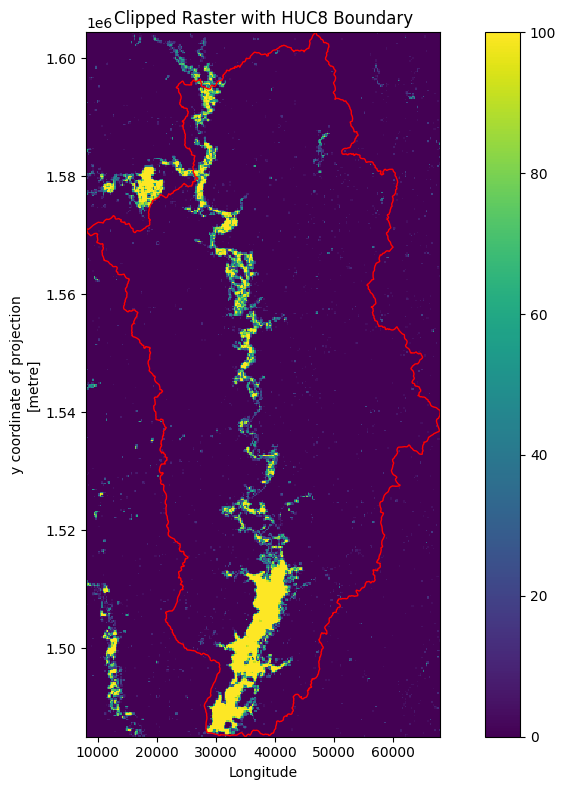

In [152]:
fig, ax = plt.subplots(figsize=(10, 8))

im2 = flood_percent_250m.plot(ax=ax)
ax.set_title("Raster with NoData filled as 0")
ax.set_xlabel("Longitude")

plt.tight_layout()

gdf.boundary.plot(ax=ax, color='red', linewidth=1)
plt.title('Clipped Raster with HUC8 Boundary')
plt.show()


## Create inputs from NWM retrospective

In [156]:
nhd_gpd = gpd.read_file("../data/boundaries/nwm_catchments_original.gpkg")

In [271]:
bbox_polygon = box(*bounds)
polygon_path = Path("../data/sample_dir/polygons_nhd.gpkg")
if polygon_path.exists():
    combined_polys = gpd.read_file(polygon_path)
else:
    # Create a GeoDataFrame from the bounding box
    bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs=gdf.crs)

    # Ensure both datasets are in the same CRS
    if nhd_gpd.crs != bbox_gdf.crs:
        nhd_gpd = nhd_gpd.to_crs(bbox_gdf.crs)

    # # Find polygons that are fully within the bounding box
    # within_polys = nhd_gpd[nhd_gpd.within(bbox_polygon)]

    # # Find polygons that intersect with the bounding box but aren't fully within it
    # intersecting_polys = nhd_gpd[nhd_gpd.intersects(bbox_polygon) & ~nhd_gpd.within(bbox_polygon)]

    # Combined result: all polygons that are either within or intersect the bbox
    combined_polys = nhd_gpd[nhd_gpd.intersects(bbox_polygon)]
    combined_polys.to_file(polygon_path, driver="GPKG")

#### Create dynamic inputs  

In [185]:
ds = ds_sm.rio.write_crs(ds_sm.attrs["esri_pe_string"], inplace = True)

In [217]:
from tqdm import trange
import xarray as xr
arr = []
_ds = ds.isel(soil_layers_stag=0).rio.reproject("EPSG:5070")

for i in trange(_ds.time.shape[0]):
    _ds_ = _ds.isel(time=i).rio.reproject("EPSG:5070")
    clipped_sm = _ds_.rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy
    )

    current_res_x, current_res_y = clipped_sm.rio.resolution()
    scale_x = abs(250 / current_res_x)
    scale_y = abs(250 / current_res_y)
    new_width = int(clipped_sm.rio.width / scale_x)
    new_height = int(clipped_sm.rio.height / scale_y)
    
    clipped_sm_250m = clipped_sm.rio.reproject(
        "EPSG:5070",
        shape=(new_height, new_width),
        resampling=Resampling.bilinear  # Use bilinear for continuous data
    )
    arr.append(clipped_sm_250m)
    
clipped_merge = xr.concat(arr, dim="time")

100%|██████████| 25/25 [00:05<00:00,  4.25it/s]


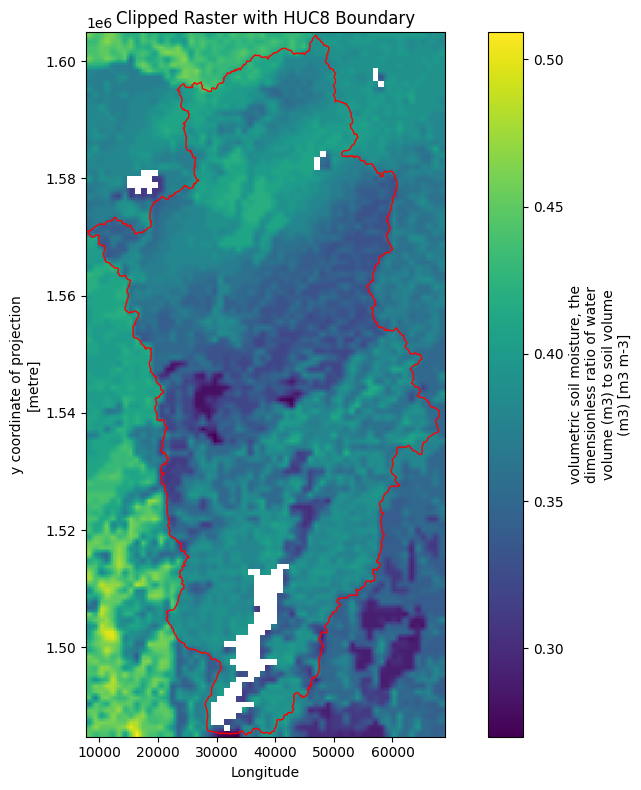

In [220]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the filled raster 
im2 = clipped_merge.isel(time=-1).plot(ax=ax)
ax.set_title("Raster with NoData filled as 0")
ax.set_xlabel("Longitude")

# Adjust layout
plt.tight_layout()

gdf.boundary.plot(ax=ax, color='red', linewidth=1)
plt.title('Clipped Raster with HUC8 Boundary')
plt.show()

In [221]:
import pandas as pd
# start_time = clipped_merge.time.values[0]
# end_time = clipped_merge.time.values[-1]

# Create hourly time range
hourly_times = pd.date_range(start=start_time, end=end_time, freq='1H')

# Create the target dataset with the new time coordinates
target = xr.Dataset(coords={"time": hourly_times})

# Perform nearest neighbor interpolation
clipped_merge_hourly = clipped_merge.interp(time=hourly_times, method='nearest')
# clipped_merge_hourly = clipped_merge_hourly.rio.write_crs(ds_sm.attrs["esri_pe_string"], inplace = True)

/var/folders/x7/3f3kh2b51z14xjz045ms8gbc0000gn/T/ipykernel_14490/2376939978.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_times = pd.date_range(start=start_time, end=end_time, freq='1H')


In [223]:
clipped_merge_hourly = clipped_merge_hourly.rio.write_crs(ds_sm.attrs["esri_pe_string"], inplace = True)

In [275]:
combined_polys = combined_polys.sort_values("ID")

In [282]:
mask = np.isin(ds_r.feature_id.values, combined_polys["ID"].values)
matching_indices = np.where(mask)[0]
clipped_ds_r = ds_r.isel(feature_id=matching_indices)
# clipped_ds_r.isel(time=0)
clipped_ds_r.shape

(73, 2484)

In [291]:
from shapely.geometry import mapping
from rasterio import features
from pyproj import CRS



crs_5070 = CRS.from_epsg(5070)

combined_polys_5070 = combined_polys.to_crs(crs_5070)

clipped_merge_hourly_5070 = clipped_merge_hourly.rio.reproject(crs_5070)

template_grid = clipped_merge_hourly.isel(time=0)
grid_crs = clipped_merge_hourly.rio.crs
if grid_crs is not None and combined_polys.crs != grid_crs:
    polygons_gdf = combined_polys.to_crs(grid_crs)
    
arr = []
for i in trange(clipped_ds_r.shape[0]):
    
    feature_ids = clipped_ds_r.feature_id.values
    runoff_values = clipped_ds_r.isel(time=i).values
    
    # Create a dictionary mapping ID -> runoff value
    runoff_map = dict(zip(feature_ids, runoff_values))
    
    # Apply the mapping to your polygons DataFrame
    combined_polys["runoff"] = combined_polys["ID"].map(runoff_map)
    
    # Create shapes and values for rasterio.features.rasterize
    shapes = [(mapping(geom), value) for geom, value in zip(combined_polys.geometry, combined_polys["runoff"])]

    # Create output array with same dimensions as template
    out_shape = template_grid.shape
    transform = template_grid.rio.transform()

    # Rasterize the polygons
    rasterized = features.rasterize(
        shapes=shapes,
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype=float,
        all_touched=False
    )

    # Convert to xarray with the same coordinates as the template
    rasterized_xr = xr.DataArray(
        rasterized,
        dims=template_grid.dims,
        coords=template_grid.coords,
        attrs={
            'long_name': 'Rasterized runoff from polygons',
            'units': 'm3/s' 
        }
    )
    arr.append(rasterized_xr)
runoff_merge = xr.concat(arr, dim="time")

100%|██████████| 73/73 [01:28<00:00,  1.21s/it]


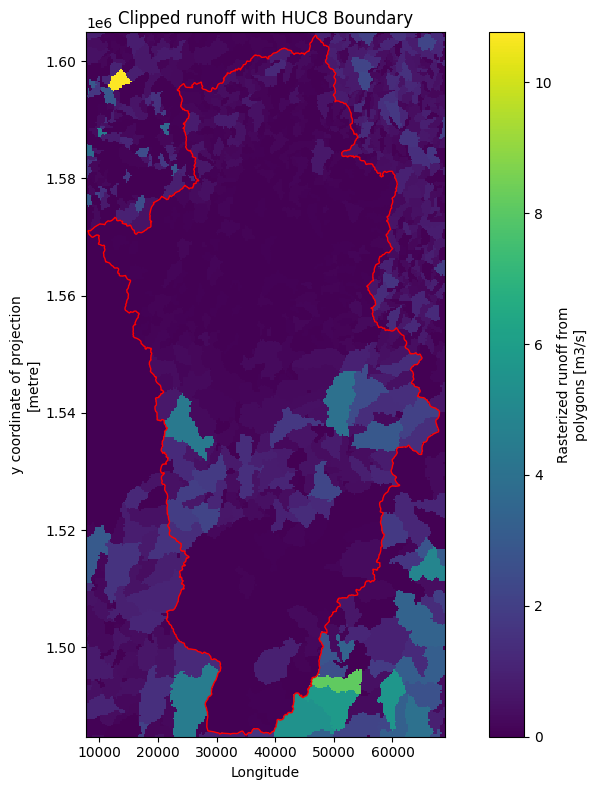

In [301]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the filled raster 
im2 = runoff_merge.isel(time=65).plot(ax=ax)
ax.set_title("Raster with NoData filled as 0")
ax.set_xlabel("Longitude")

# Adjust layout
plt.tight_layout()

gdf.boundary.plot(ax=ax, color='red', linewidth=1)
plt.title('Clipped runoff with HUC8 Boundary')
plt.show()

## Static attributes (flow accumulation, direction, surface water extent)

In [323]:
flow_acc = rioxarray.open_rasterio("/Users/taddbindas/projects/NGWPC/f1_trainer/data/hydrosheds/hyd_na_acc_15s.tif")
flow_dir = rioxarray.open_rasterio("/Users/taddbindas/projects/NGWPC/f1_trainer/data/hydrosheds/hyd_na_dir_15s.tif")
surface_extent = rioxarray.open_rasterio("/Users/taddbindas/projects/NGWPC/f1_trainer/data/extents/extent_100W_40Nv1_4_2021.tif")

In [324]:
flow_acc_5070 = flow_acc.rio.reproject("EPSG:5070")
clipped_flow_acc = flow_acc_5070.rio.clip_box(
    minx=minx,
    miny=miny,
    maxx=maxx,
    maxy=maxy
)
flow_dir_5070 = flow_dir.rio.reproject("EPSG:5070")
clipped_flow_dir = flow_dir_5070.rio.clip_box(
    minx=minx,
    miny=miny,
    maxx=maxx,
    maxy=maxy
)
surface_extent_5070 = surface_extent.rio.reproject("EPSG:5070")
clipped_surface_extent = surface_extent_5070.rio.clip_box(
    minx=minx,
    miny=miny,
    maxx=maxx,
    maxy=maxy
)

In [325]:
current_res_x, current_res_y = clipped_flow_acc.rio.resolution()
scale_x = abs(250 / current_res_x)
scale_y = abs(250 / current_res_y)
new_width = int(clipped_flow_acc.rio.width / scale_x)
new_height = int(clipped_flow_acc.rio.height / scale_y)

clipped_flow_acc_250m = clipped_flow_acc.rio.reproject(
    "EPSG:5070",
    shape=(new_height, new_width),
    resampling=Resampling.bilinear  # Use bilinear for continuous data
)

current_res_x, current_res_y = clipped_flow_dir.rio.resolution()
scale_x = abs(250 / current_res_x)
scale_y = abs(250 / current_res_y)
new_width = int(clipped_flow_dir.rio.width / scale_x)
new_height = int(clipped_flow_dir.rio.height / scale_y)

clipped_flow_dir_250m = clipped_flow_dir.rio.reproject(
    "EPSG:5070",
    shape=(new_height, new_width),
    resampling=Resampling.bilinear  # Use bilinear for continuous data
)

current_res_x, current_res_y = clipped_surface_extent.rio.resolution()
scale_x = abs(250 / current_res_x)
scale_y = abs(250 / current_res_y)
new_width = int(clipped_surface_extent.rio.width / scale_x)
new_height = int(clipped_surface_extent.rio.height / scale_y)

clipped_surface_extent_250m = clipped_surface_extent.rio.reproject(
    "EPSG:5070",
    shape=(new_height, new_width),
    resampling=Resampling.bilinear  # Use bilinear for continuous data
)

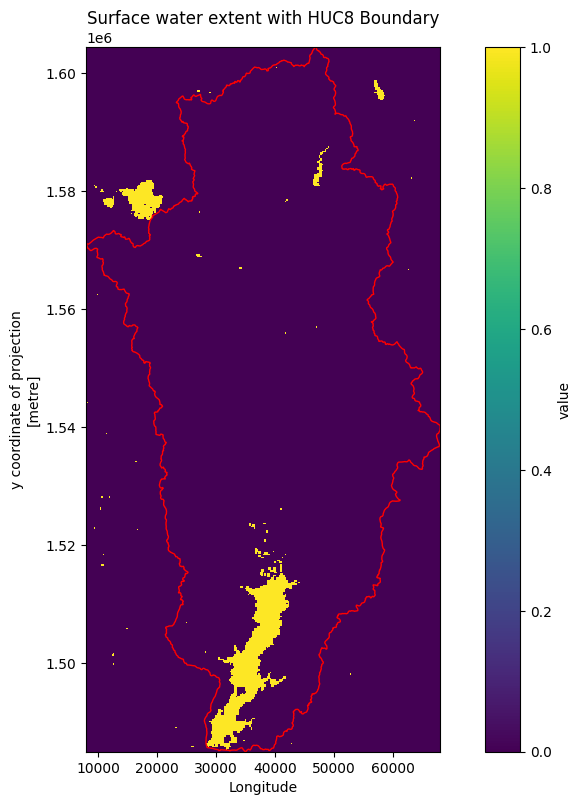

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 8))

# im2 = clipped_surface_extent_250m.plot(ax=ax)
# ax.set_title("Flow dir raster")
# ax.set_xlabel("Longitude")

# plt.tight_layout()

# gdf.boundary.plot(ax=ax, color='red', linewidth=1)
# plt.title('Surface water extent with HUC8 Boundary')
# plt.show()

## Save to disk

In [327]:
flood_percent_250m.rio.to_raster("../data/sample_dir/flood_percent_250m.tif")
clipped_flow_acc_250m.rio.to_raster("../data/sample_dir/flow_acc_250m.tif")
clipped_flow_dir_250m.rio.to_raster("../data/sample_dir/flow_dir_250m.tif")
clipped_surface_extent_250m.rio.to_raster("../data/sample_dir/surface_extent_250m.tif")

In [304]:
sm_path = Path("../data/sample_dir/soil_moisture.zarr")
r_path = Path("../data/sample_dir/router.zarr")
if not sm_path.exists():
    clipped_merge_hourly.to_zarr(sm_path)
if not r_path.exists():
    runoff_merge.to_zarr(r_path)